Run CINEMA-OT analysis to look at synergy between perturbations

In [10]:
# Imports
import numpy as np
import scanpy as sc
import cinemaot as co
from cinemaot import utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pyturbseq.utils import filter_adata
%matplotlib inline

In [15]:
# Preprocessing
data_dir = "../../data"
data = sc.read_h5ad(os.path.join(data_dir, "simplified_seurat.h5ad"))
source = "preinf"
adatas = {
    "RT": data[data.obs.sourceCond == f"{source}_RT"],
    "noRT": data[data.obs.sourceCond == f"{source}_noRT"]
}

In [82]:
output_dir = "../../output/cinema_ot_analysis"

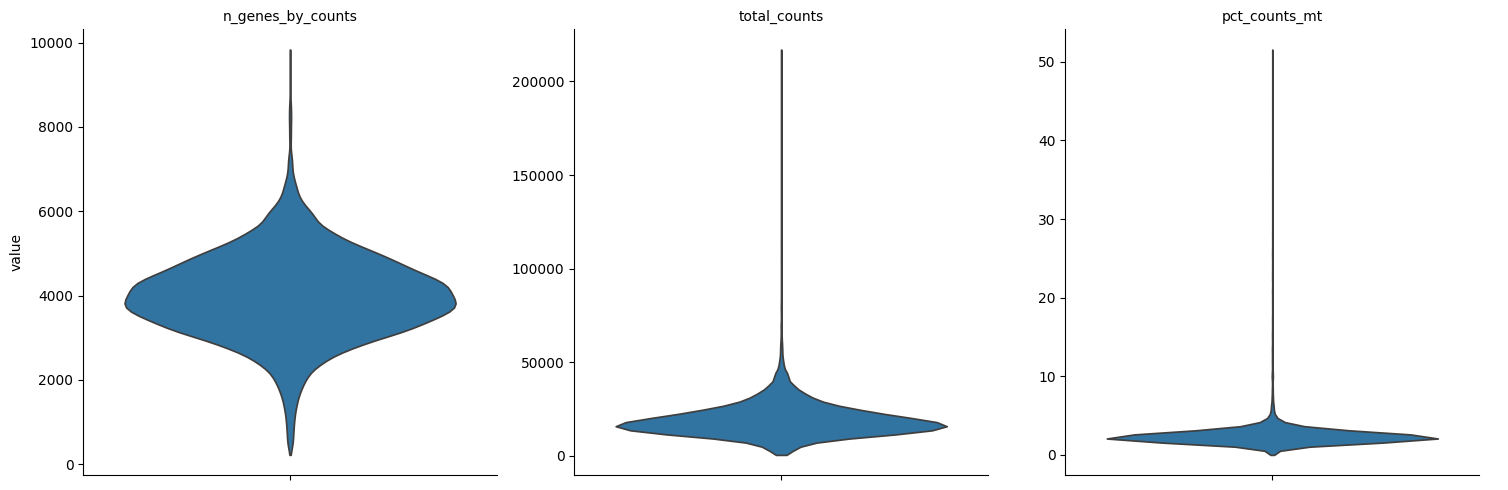

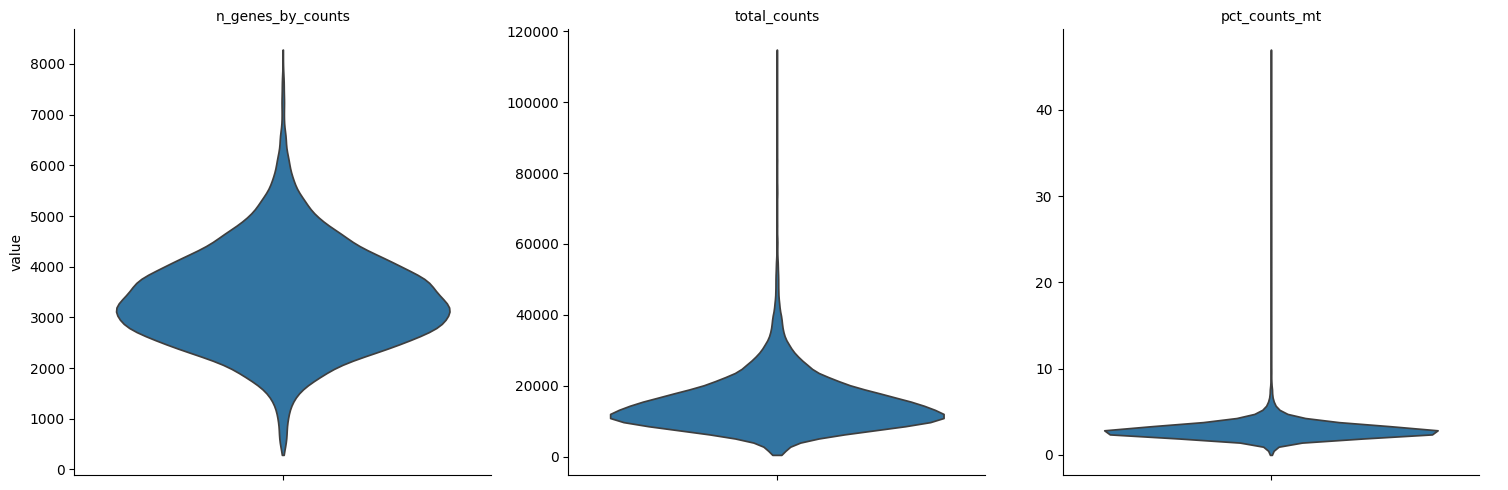

In [21]:
qced_adatas = {}
for key, subset_data in adatas.items():
    subset_data.var['mt'] = subset_data.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(subset_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(subset_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], stripplot=False, multi_panel=True)
    subset_data = filter_adata(
        subset_data,
        obs_filters=[
            "n_genes_by_counts > 2000",
            "pct_counts_mt < 20",
            "total_counts > 6000",
        ],
        var_filters=[
            'n_cells_by_counts > 50',
            'total_counts > 100'
        ]
    )
    qced_adatas[key] = subset_data

In [27]:
# Do a coverage check for each sgRNA. We will eliminate any sgRNA from consideration
# that doesn't have at least 5 cells in both single and combination
coverage_checked_adatas = {}
for key, subset_data in qced_adatas.items():
    mask = subset_data.obs.sgRNA.str.contains("_")
    combinations = subset_data.obs.sgRNA[mask]
    sgRNAs_to_keep = ["non-targeting"] # Keep non-targeting by default for normalization
    sgRNA_counts = subset_data.obs.sgRNA.value_counts()
    for combination in combinations:
        geneA = combination.split("_")[0]
        geneB = combination.split("_")[1]
        if sgRNA_counts[combination].item() > 5 and sgRNA_counts[geneA].item() > 5 and sgRNA_counts[geneB].item() > 5:
            sgRNAs_to_keep.extend([geneA, geneB, combination])
    subset_data = subset_data[subset_data.obs.sgRNA.isin(sgRNAs_to_keep)].copy()
    coverage_checked_adatas[key] = subset_data

In [28]:
for condition, subset_data in coverage_checked_adatas.items():
    sc.pp.normalize_total(coverage_checked_adatas[condition])
    sc.pp.log1p(coverage_checked_adatas[condition])

In [37]:
for condition, subset_data in coverage_checked_adatas.items():
    sc.pp.highly_variable_genes(subset_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
    subset_data = subset_data[:, subset_data.var.highly_variable]
    sc.tl.pca(subset_data, svd_solver="arpack")
    sc.pp.neighbors(subset_data, n_neighbors=10, n_pcs=40)
    sc.tl.umap(subset_data)
    coverage_checked_adatas[condition] = subset_data

/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


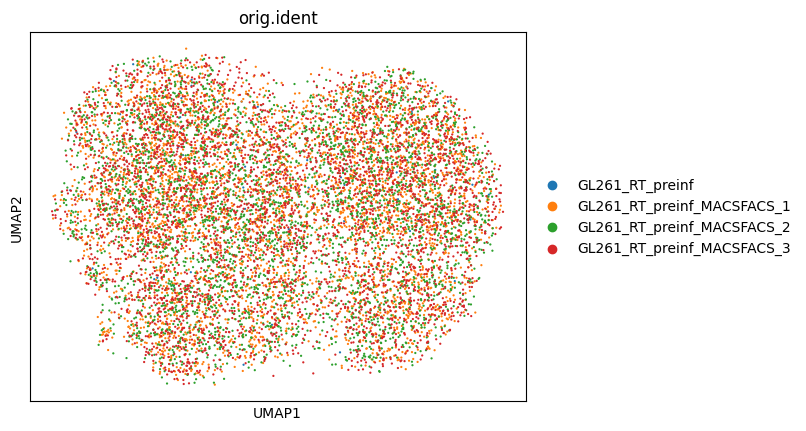

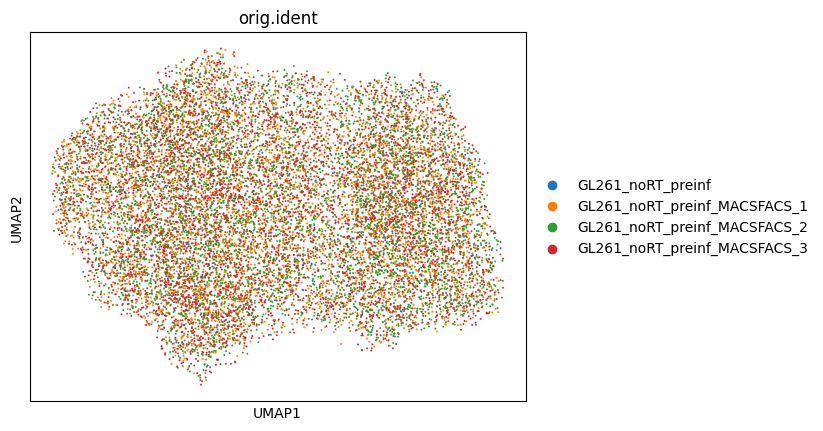

In [43]:
sc.pl.umap(coverage_checked_adatas["RT"], color = "orig.ident")
sc.pl.umap(coverage_checked_adatas["noRT"], color = "orig.ident")

In [49]:
# For each double perturbation in each context, create a synergy score matrix
def find_synergy_matrices(adata):
    synergy_matrices = {}
    sgRNAs = [sgRNA for sgRNA in pd.unique(adata.obs.sgRNA) if "_" in sgRNA]
    for combo in sgRNAs:
        synergy_matrix = co.cinemaot.synergy(
            adata,
            "sgRNA",
            "non-targeting",
            combo.split("_")[0],
            combo.split("_")[1],
            combo,
            dim=10,
            thres=0.5,
            smoothness=1e-3,
            eps=1e-3,
            mode="parametric"
        )
        synergy_matrices[combo] = synergy_matrix
    return synergy_matrices

In [50]:
synergy_matrices_by_condition = {}
for condition, adata in coverage_checked_adatas.items():
    adata = coverage_checked_adatas[condition]
    synergy_matrices_by_condition[condition] = find_synergy_matrices(adata)

/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/s

RT


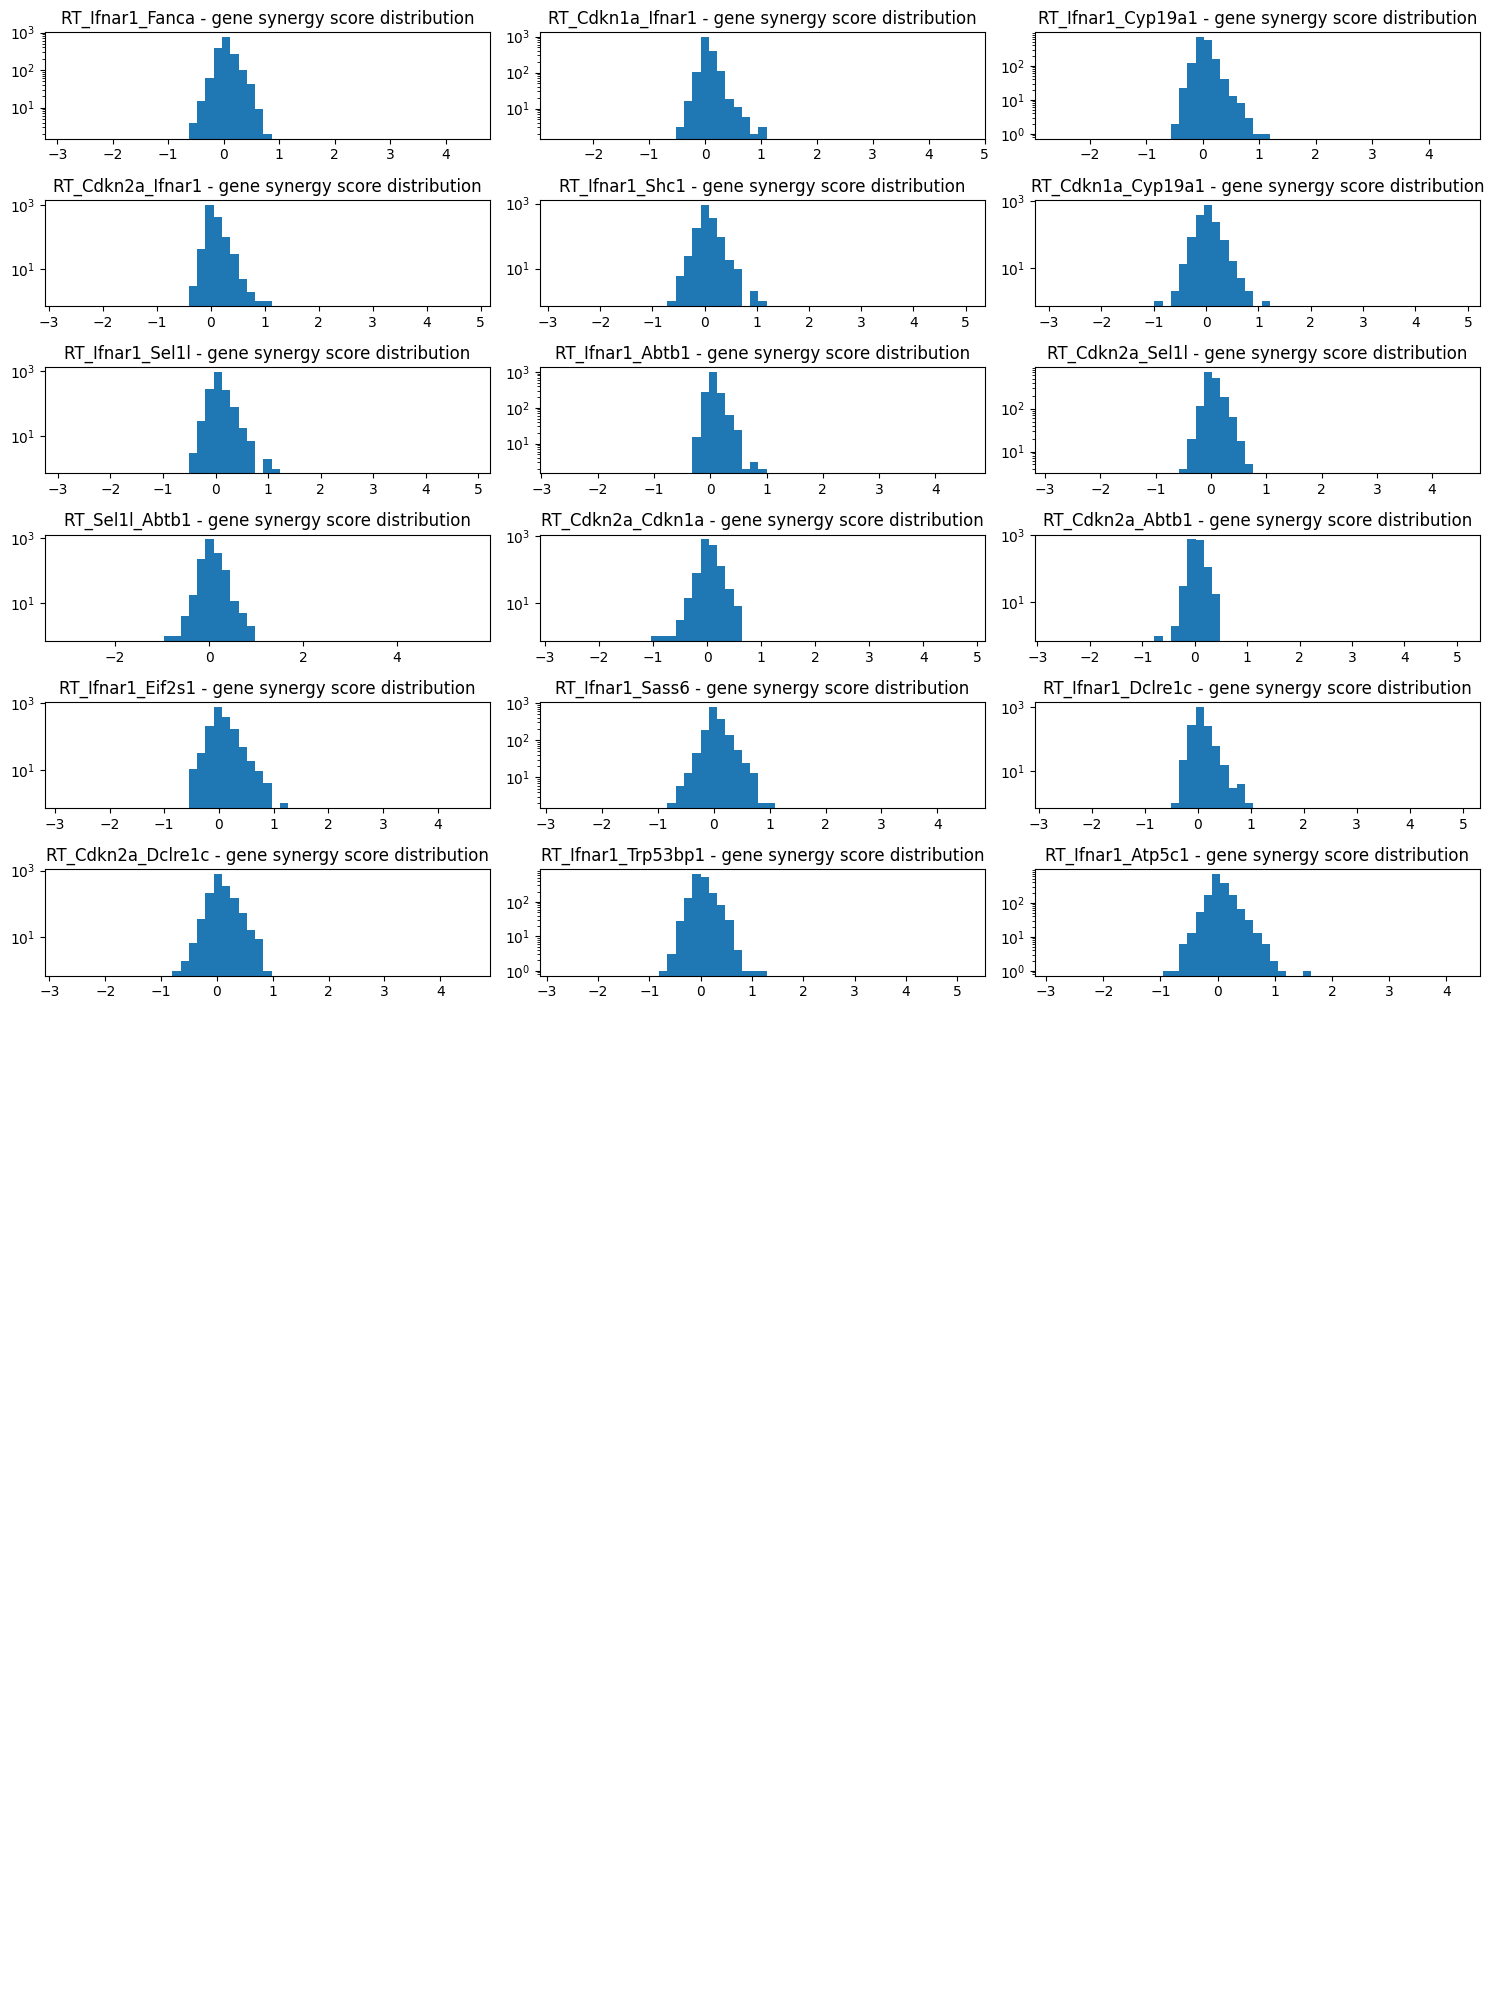

noRT


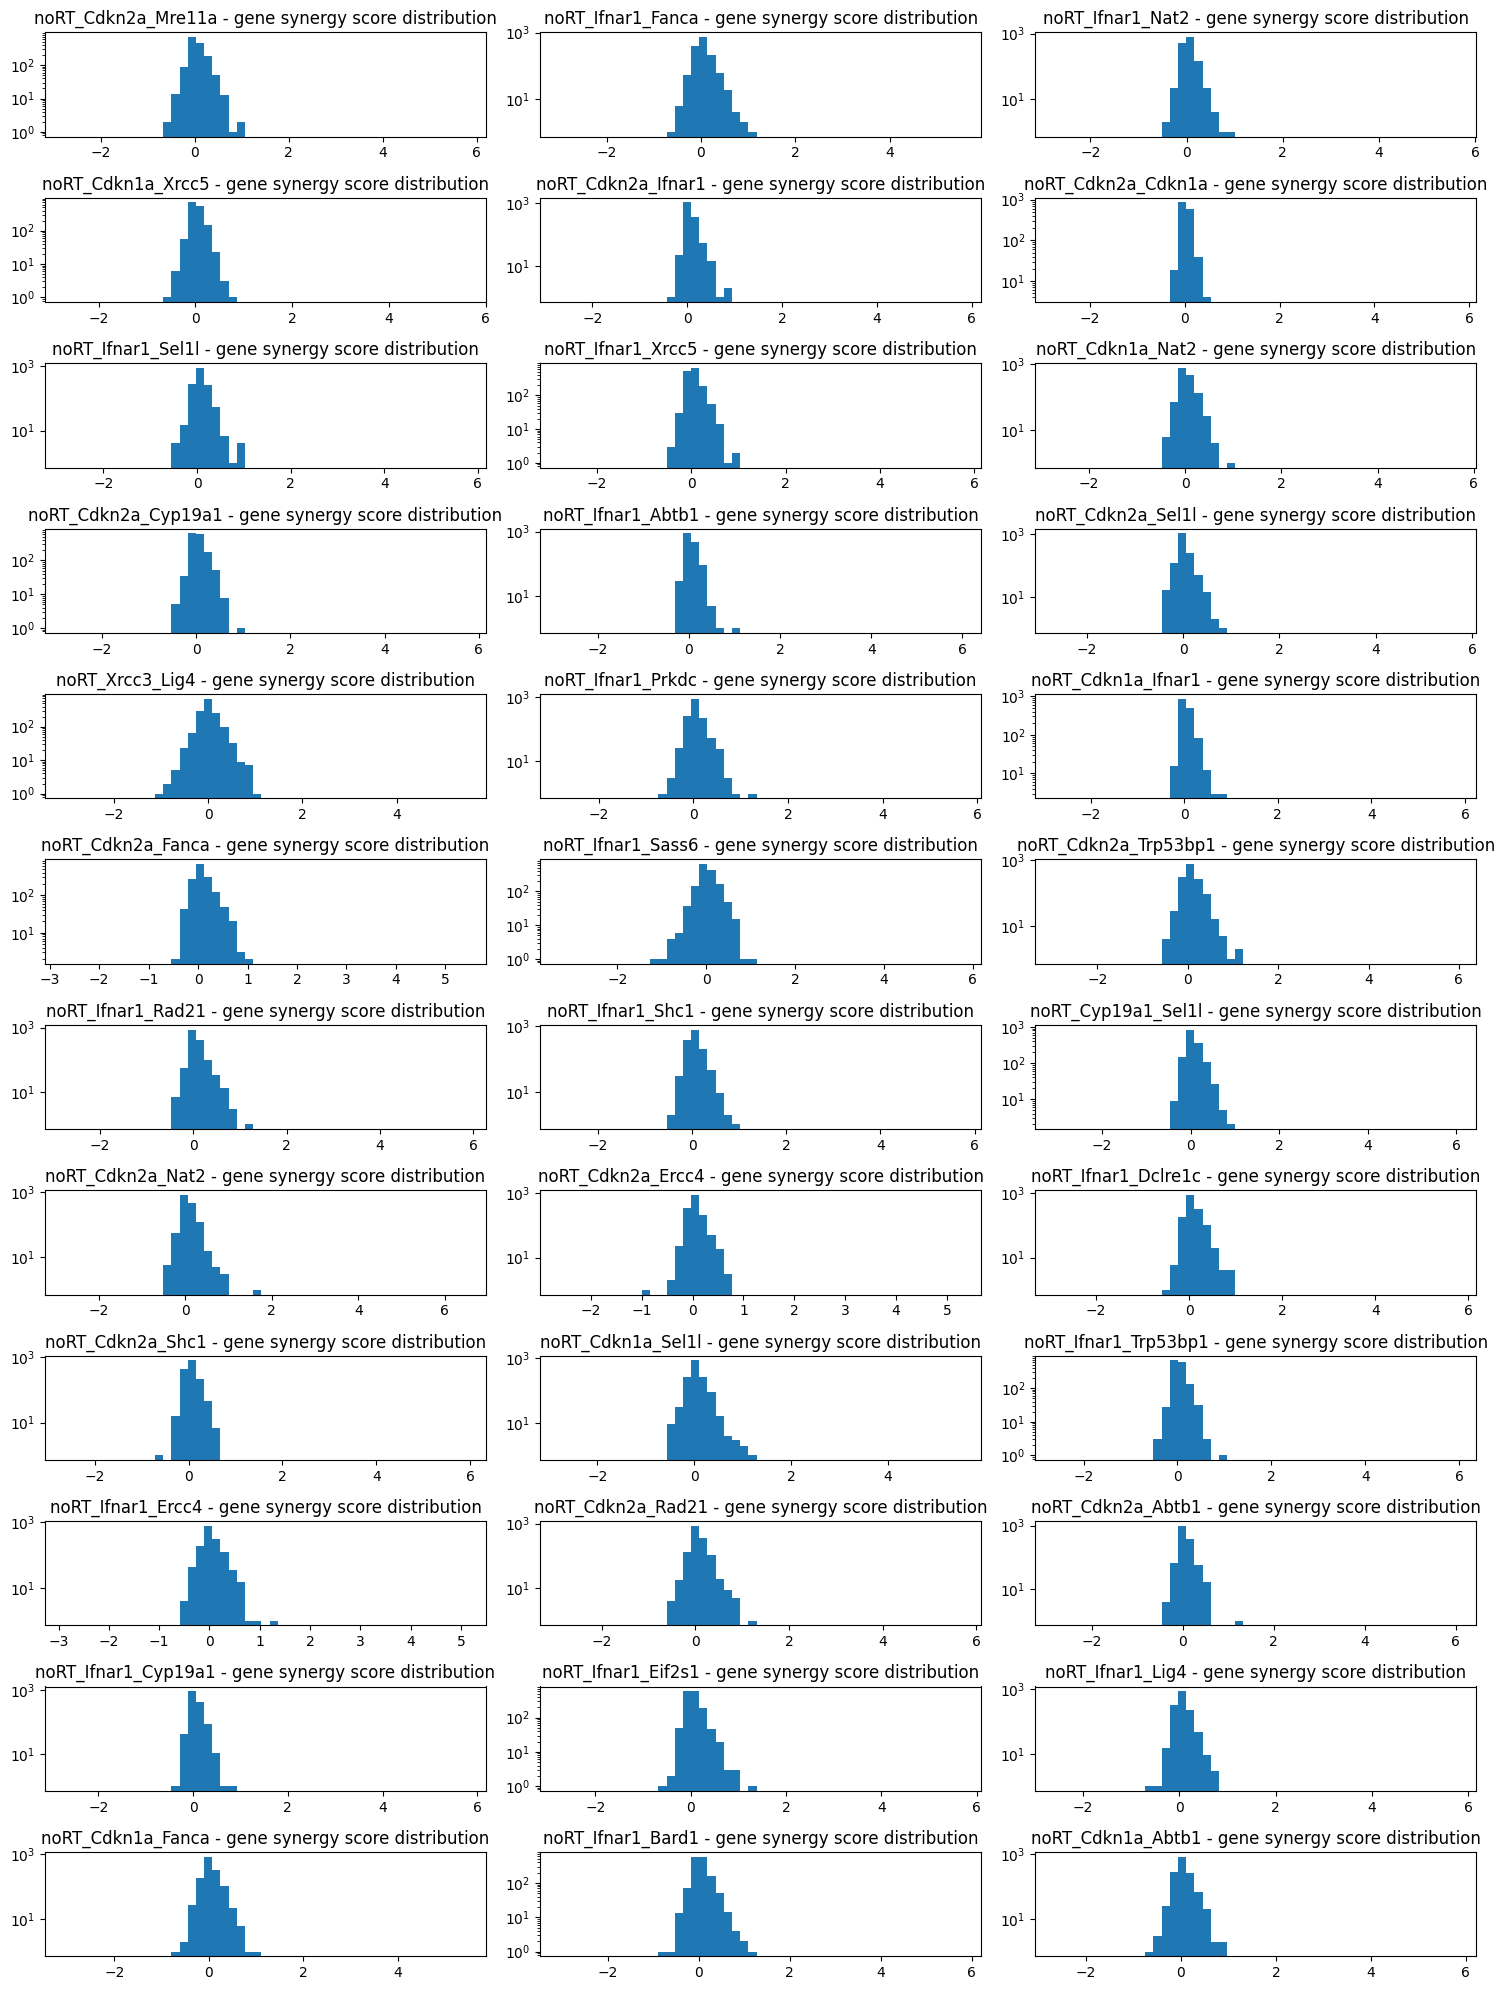

In [85]:
for context in synergy_matrices_by_condition:
    print(context)
    synergy_matrices = synergy_matrices_by_condition[context]
    nrows = 12
    ncols = 3
    
    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))
    axes = axes.flatten()
    count = 0
    
    for name, matrix in synergy_matrices.items():
        ax = axes[count]
        # Calculate the data range and set bin edges
        data_range = np.ptp(np.mean(matrix.X, axis=0))  # Peak-to-peak (max-min) of the data
        bin_edges = np.linspace(np.min(matrix.X), np.max(matrix.X), num=50)  # Create 50 bin edges from min to max
        # Create histogram with specified bin edges
        ax.hist(np.mean(matrix.X, axis=0), bins=bin_edges, log = True)
        ax.set_title(f"{context}_{name} - gene synergy score distribution")
        count += 1
    
    # Turn off any extra subplots
    for i in range(len(synergy_matrices), len(axes)):
        axes[i].axis('off')
    
    # Adjust layout for better spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{context}_histograms_of_synergy_scores.pdf"), format ="pdf", bbox_inches="tight")
    plt.show()

In [86]:
for context in synergy_matrices_by_condition:
    synergy_matrices = synergy_matrices_by_condition[context]
    for name, matrix in synergy_matrices.items():
        synergyscore = np.linalg.norm(matrix.X[:,np.abs(np.mean(matrix.X,axis=0))>0],axis=1)
        matrix.obs['synergy_l2_norm'] = synergyscore

In [87]:
shared_perturbations = set.intersection(*(set(synergy_matrices.keys()) for _, synergy_matrices in synergy_matrices_by_condition.items()))

In [88]:
# Construct a series of dataframes that include perturbation, synergy, and context information
df_list = []
for condition, synergy_matrices in synergy_matrices_by_condition.items():
    for perturbation, adata in synergy_matrices.items():
        if perturbation in shared_perturbations:
            temp_df = pd.DataFrame({
                'Perturbation': perturbation,
                'Synergy': adata.obs['synergy_l2_norm'],
                'Condition': condition
            })
            df_list.append(temp_df)

# Concatenate all the data frames
combined_df = pd.concat(df_list)

In [89]:
# Create a sorting key so we can sort by the experimental context
order = ["noRT", "RT"]

def sort_key(value):
    if value in order:
        return order.index(value)
    else:
        return len(order) + 1

# Apply the custom sorting key function to the column and sort by it
combined_df = combined_df.iloc[combined_df['Condition'].map(sort_key).argsort()]

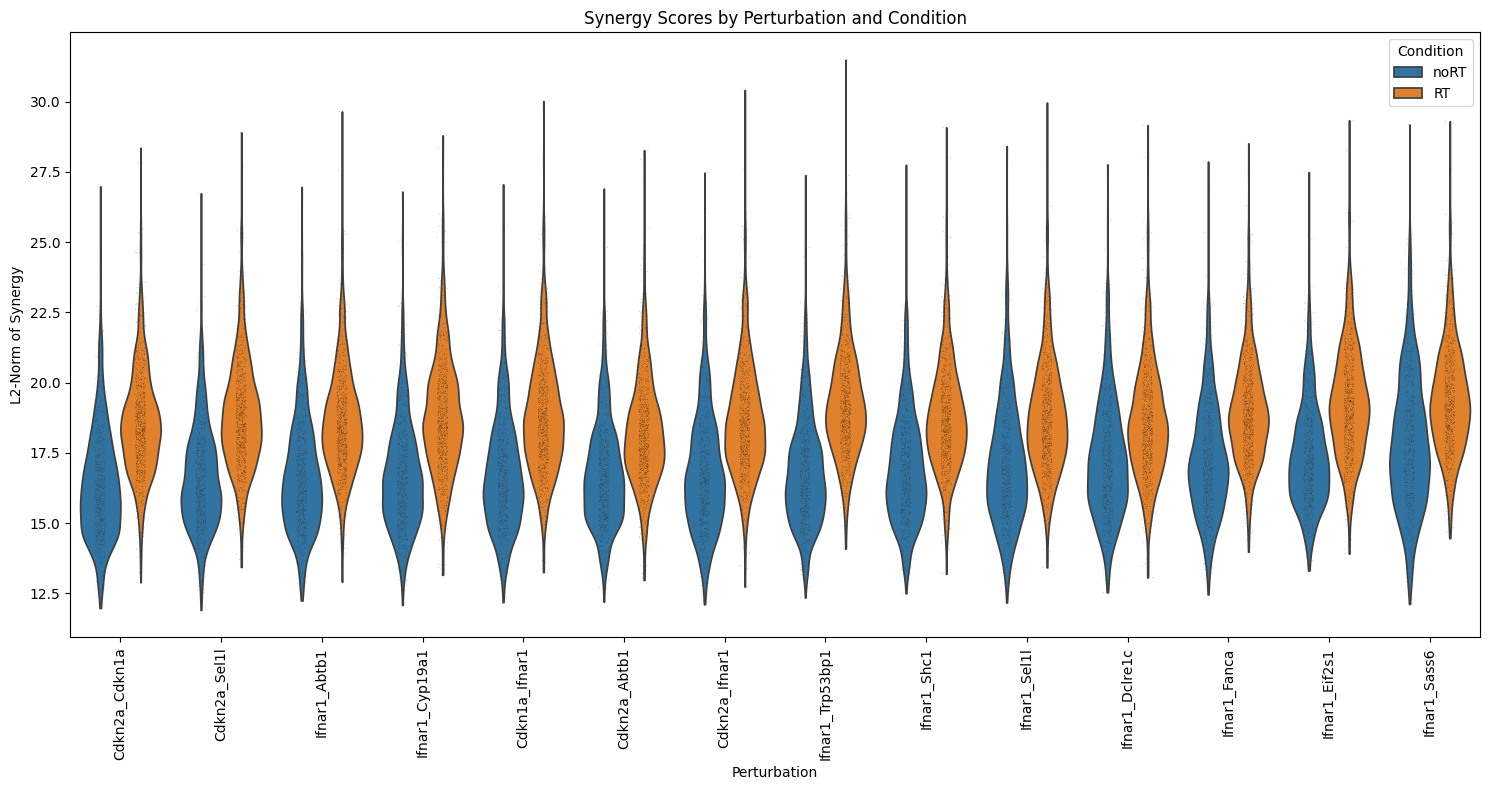

In [90]:
# Calculate median synergy and sort perturbations
median_synergy = combined_df[combined_df['Condition'] == 'noRT'].groupby('Perturbation')['Synergy'].median().sort_values()
perturbation_order = median_synergy.index.tolist()

fig, ax = plt.subplots(figsize=(15, 8))

sns.violinplot(ax=ax, x='Perturbation', y='Synergy', hue='Condition', data=combined_df, 
               inner=None, bw_method=0.2, cut=0, density_norm='width', order=perturbation_order)
sns.stripplot(ax=ax, x='Perturbation', y='Synergy', hue='Condition', data=combined_df, 
              dodge=True, palette='dark:k', alpha=0.5, size=0.5, jitter=True, order=perturbation_order)

ax.set_ylabel("L2-Norm of Synergy")
ax.set_title("Synergy Scores by Perturbation and Condition")

plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Condition')
plt.tight_layout()

# Uncomment to save the figure
# plt.savefig(os.path.join(output_dir, 'combined_synergy_plot.pdf'), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()